In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from jyquickhelper import add_notebook_menu

In [2]:
add_notebook_menu()

# Minimisation de la variance en ligne - Application

On utilise les données INSEE du cours. Elles contiennent : 

- la croissance du PIB français $y_t$, trimestre par trimestre, depuis début 1988 jusqu’à mi-2011 (disponible uniquement à la fin du trimestre t)
- un indicateur du climat des affaires $c_t$, produit par l’INSEE sur la base d’enquêtes auprès des entreprises, disponible dans le courant du trimestre

In [3]:
# Chargement des données
db = pd.read_csv("donnes_insee.csv", sep=";")

Notre objectif est de mettre en oeuvre l'algorithme de minimisation de la variance en ligne proposé par Warmuth et Kuzmin (2006). 

## Experts

On crée 6 experts :

- $\hat{y}_{t,1} = y_{t-1}$
- $\hat{y}_{t,2} = 0.4$ 
- $\hat{y}_{t,3}$ qui est aléatoire et tiré suivant la loi $N(\mu;\sigma^2)$,  $\mu= 0,4$ et $\sigma^2 = 0,22$ (bien noter qu’on n’utilise pas pour le moment la variable $c$).
- $\hat{y}_{t,4} = \hat{a} + \hat(b) y_{t-1}$ (offline)
- $\hat{y}_{t,5} = \hat{a} + \hat{b}c_t$ où $\hat{a}$ (offline)
- $\hat{y}_{t,6} = \hat{a}+ \hat{b}c_t+ \hat{\gamma} y_{t-1}$ (offline)

Par la suite on s'intéressera à deux regroupements d'experts:

- E3= $\{y_1, y_2, y_3\}$
- E6= $\{y_1, y_2, y_3, y_4, y_5, y_6\}$

In [4]:
db.head()

,t,y,c
0,1988Q1,1.2,115.0000
1,1988Q2,0.6,114.6667
2,1988Q3,0.8,116.0000
3,1988Q4,0.4,114.6667
4,1989Q1,1.2,116.3333


In [5]:
np.random.seed(100)
# E3
db["y1"]=db.y.shift(1)
db["y2"]=.4
db["y3"]=np.random.normal(.4,.22,len(db))

# E6
from sklearn.linear_model import LinearRegression

## AR(1) : y= a + beta * y_{-1}
lm1= LinearRegression()
lm1.fit(db.y.shift(-1)[:-1].values.reshape(-1,1),db.y[:-1].values.reshape(-1,1))
db["y4"]= lm1.predict(db.y.values.reshape(-1,1))
db.y4= db.y4.shift(1)
## Business climate : y = a + beta * c
lm2= LinearRegression()
lm2.fit(db.c.values.reshape(-1,1), db.y.values.reshape(-1,1))
db["y5"]= lm2.predict(db.c.values.reshape(-1,1))
## Business climate + AR(1) : y = a + beta * c + gamma * y_{-1}
X= pd.concat([db.y.shift(-1),db.c], axis=1)
X_pred= X.fillna(-99)
lm3= LinearRegression()
lm3.fit(X.values.reshape(-1,2)[:-1,:],db.y[:-1].values.reshape(-1,1))
db["y6"]= lm3.predict(X_pred.values.reshape(-1,2))
db.y6= db.y6.shift(1)

In [6]:
# Aperçu des données
db.head()

,t,y,c,y1,y2,y3,y4,y5,y6
0,1988Q1,1.2,115.0000,NaN,0.4,0.015052,NaN,0.784520,NaN
1,1988Q2,0.6,114.6667,1.2,0.4,0.475390,0.560184,0.776178,0.788372
2,1988Q3,0.8,116.0000,0.6,0.4,0.653668,0.466063,0.809549,0.769327
3,1988Q4,0.4,114.6667,0.8,0.4,0.344464,0.497437,0.776178,0.824651
4,1989Q1,1.2,116.3333,0.4,0.4,0.615891,0.434689,0.817891,0.748470


## Perte

In [7]:
# Définition de la fonction de perte
def loss(y_pred, y):
    """
    Cette fonction détermine la fonction de
    perte utilisée dans le cadre de notre algo-
    rithme d'apprentissage. On utilise la perte
    quadratique.
    
    Beware: cette fonction doit être bornée ET 
    convexe dans cette version de l'algorithme
    """
    return (y_pred-y)**2 

In [8]:
# Définition des vecteurs de perte
# Groupe Expert 3
loss_vec_GE3=np.array([loss(db.y1,db.y),
                       loss(db.y2,db.y),
                       loss(db.y3,db.y),]).T

# Groupe Expert 6
loss_vec_GE6=np.array([loss(db.y1,db.y),
                       loss(db.y2,db.y),
                       loss(db.y3,db.y),
                       loss(db.y4,db.y),
                       loss(db.y5,db.y),
                       loss(db.y6,db.y),]).T

## Algorithme

In [9]:
def war_algo(loss_vec, eta=.3, t0=1):
    """
    Cette fonction implémente l'algorithme de 
    minimisation de la variance en ligne dans un
    cadre d'apprentissage en ligne avec experts. 
    Voir Warmuth et Kuzmin (2006)
    
    Hyper-paramètre(s)
    eta : (st pos) parametre de tuning
    
    Argument(s)
    M : le nombre d'experts
    loss_vec : (np.array(T,M)) le vecteur 
    des pertes des experts à chaque date
    t0: la première période considérée dans nos 
    itérations
    
    Sortie(s)
    W : (np.array(T,M,1)) vecteur des poids au 
    cours des T périodes
    C : (np.array(T-t0,M,M)) vecteur des matrices 
    de variance-covariance au cours des T-t0 périodes
    
    Beware : on commence en t=1 car y1=nan en période 0 
    """
    # Init
    M= loss_vec.shape[1] # Détermine le nombre d'experts
    w= (np.ones(M)/M).reshape(M,1) # Poids répartis de manière uniforme
    W= [w,] # Ce vecteur récolte les poids de manière itérative
    C= [] # Ce vecteur récolte les matrices de var-covar

    # Date t
    for i in range(t0,len(db)): # Attention, par défaut on commence à t0=1
        l= loss_vec[i].reshape(M,1) # Mx1
        l_bar= l.T.dot(l/M) # 1x1
        

        c= (1/M) * (l-l_bar).dot((l-l_bar).T) # MxM
        cw= c.dot(w) # Mx1

        w_num= np.exp(-eta * cw) * w # Mx1
        w_denom= sum(w_num) # Mx1
        w_new= w_num/w_denom # Mx1

        W+=[w_new]
        C+=[c]

        w=w_new
       
    #print(W)
    C=np.array(C)
    W=np.array(W).reshape(len(db),M)
    return(C,W)

## Résultats

In [10]:
# Calcul des poids et matrices de var-covariance pour différents
# sets d'experts et différentes valeurs de eta

## GE3
C_E3_01, W_E3_01= war_algo(loss_vec= loss_vec_GE3, eta= .1)
#C_E3_05, W_E3_05= war_algo(loss_vec= loss_vec_GE3, eta= .5)
C_E3_2, W_E3_2= war_algo(loss_vec= loss_vec_GE3, eta= 2)
C_E3_6, W_E3_6= war_algo(loss_vec= loss_vec_GE3, eta= 6)
C_E3_10, W_E3_10= war_algo(loss_vec= loss_vec_GE3, eta= 10)

## GE6
C_E6_01, W_E6_01=war_algo(loss_vec= loss_vec_GE6, eta= .1)
#C_E6_05, W_E6_05=war_algo(loss_vec= loss_vec_GE6, eta= .5)
C_E6_2, W_E6_2=war_algo(loss_vec= loss_vec_GE6, eta= 2)
C_E6_6, W_E6_6=war_algo(loss_vec= loss_vec_GE6, eta= 6)
C_E6_10, W_E6_10=war_algo(loss_vec= loss_vec_GE6, eta= 10)

In [11]:
# Vec
C_E3_vec= [C_E3_01, C_E3_2, C_E3_6, C_E3_10]
c_E6_vec= [C_E6_01, C_E6_2, C_E6_6, C_E6_10]
W_E3_vec= [W_E3_01, W_E3_2, W_E3_6,  W_E3_10]
W_E6_vec= [W_E6_01, W_E6_2, W_E6_6, W_E6_10]
eta_vec= [".1" , "2", "6", "10"]

### Poids

In [12]:
def extract_weight(W):
    """Cette fonction permet d'extraire les vecteurs
    de poids de chacun des experts
    
    Argument(s)
    - W : (np.array(T,M,1)) tel que renvoyé par war_algo
    
    Sortie :
    - wi : (M listes de T lignes) Ex:
    w1, ..., w6 = extract_weight(W_E6_01)    
    """
    M=W.shape[1]
    w=[("w"+str(i+1)) for i in range(M)]
    for i in range(M):
        w[i]=[W[j][i] for j in range(len(db))]    
    return w

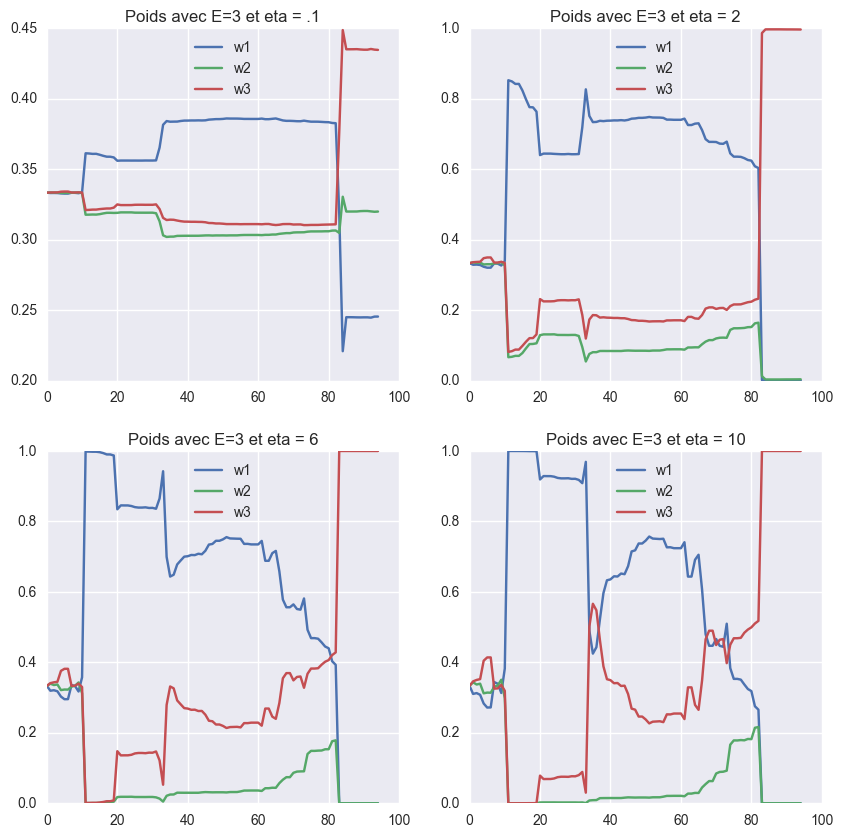

In [13]:
# Plot pour E=3
plt.figure(figsize=(10,10))
j=0
for W in W_E3_vec:
    j+=1
    plt.subplot(2,2,j)
    for i in range(W.shape[1]):
        plt.plot(extract_weight(W)[i],label="w"+str(i+1))
    plt.title("Poids avec E=3 et eta = {0}".format(eta_vec[j-1]))
    plt.legend(loc=9);

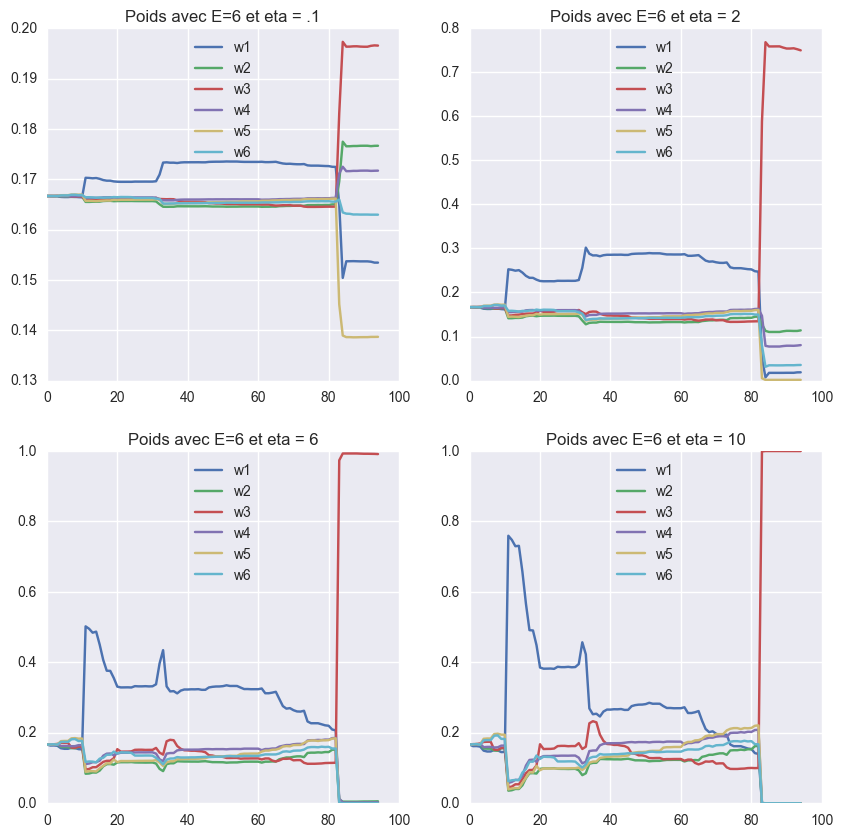

In [14]:
# Plot pour E=6
plt.figure(figsize=(10,10))
j=0
for W in W_E6_vec:
    j+=1
    plt.subplot(2,2,j)
    for i in range(W.shape[1]):
        plt.plot(extract_weight(W)[i],label="w"+str(i+1))
    plt.title("Poids avec E=6 et eta = {0}".format(eta_vec[j-1]))
    plt.legend(loc=9);

Remarques : 

- A mesure que $\eta \rightarrow \infty$, l'algorithme tend à se spécialiser sur la minimisation de la perte "instantanée". En contrepartie, il accorde moins d'importance à l'enthropie (mesurée par la divergence de Kullback-Leibler). On constate ainsi une plus forte volatilité des poids à mesure que $\eta$ grandit. On peut également s'attendre à ce que cela se traduise par une baisse des performances de l'algorithme (erreur de généralisation). 
- **E3** et **E6** :$w$ tend à charger successivement $\hat{y}_1$ et $\hat{y}_3$. Au contraire, l'estimateur EWA conduisait à charger respectivement $\hat{y}_2$ et $\hat{y}_5$.

[Graphiques intéressants]


### Prédictions

In [15]:
def pred(yhat_vec, weight_vec):
    """
    Cette fonction calcule les prédictions as-
    sociées (y.w)
    
    Argument(s) :
    - yhat_vec : le vecteur des prédictions des
    M experts (np.array(T,M))
    - weight_vec : le vecteur des poids (np.array(T,M))
    
    Sortie(s) :
    - np.array(T,)"""
    return np.array([yhat_vec[i+1].dot(weight_vec[i]) \
                     for i in range(len(weight_vec)-1)])

In [16]:
# Rearrange data
y_E3=db[pd.Index(["y1","y2","y3"])].values
y_E6=db[pd.Index(["y1","y2","y3","y4","y5","y6"])].values

war_E3_pred_01= pred(yhat_vec=y_E3,weight_vec=W_E3_01)
war_E3_pred_2= pred(yhat_vec=y_E3,weight_vec=W_E3_2)
war_E3_pred_6= pred(yhat_vec=y_E3,weight_vec=W_E3_6)
war_E3_pred_10= pred(yhat_vec=y_E3,weight_vec=W_E3_10)

war_E6_pred_01= pred(yhat_vec=y_E6,weight_vec=W_E6_01)
war_E6_pred_2= pred(yhat_vec=y_E6,weight_vec=W_E6_2)
war_E6_pred_6= pred(yhat_vec=y_E6,weight_vec=W_E6_6)
war_E6_pred_10= pred(yhat_vec=y_E6,weight_vec=W_E6_10)

war_E3_pred_vec=[war_E3_pred_01,war_E3_pred_2,war_E3_pred_6,war_E3_pred_10]
war_E6_pred_vec=[war_E6_pred_01,war_E6_pred_2,war_E6_pred_6,war_E6_pred_10]

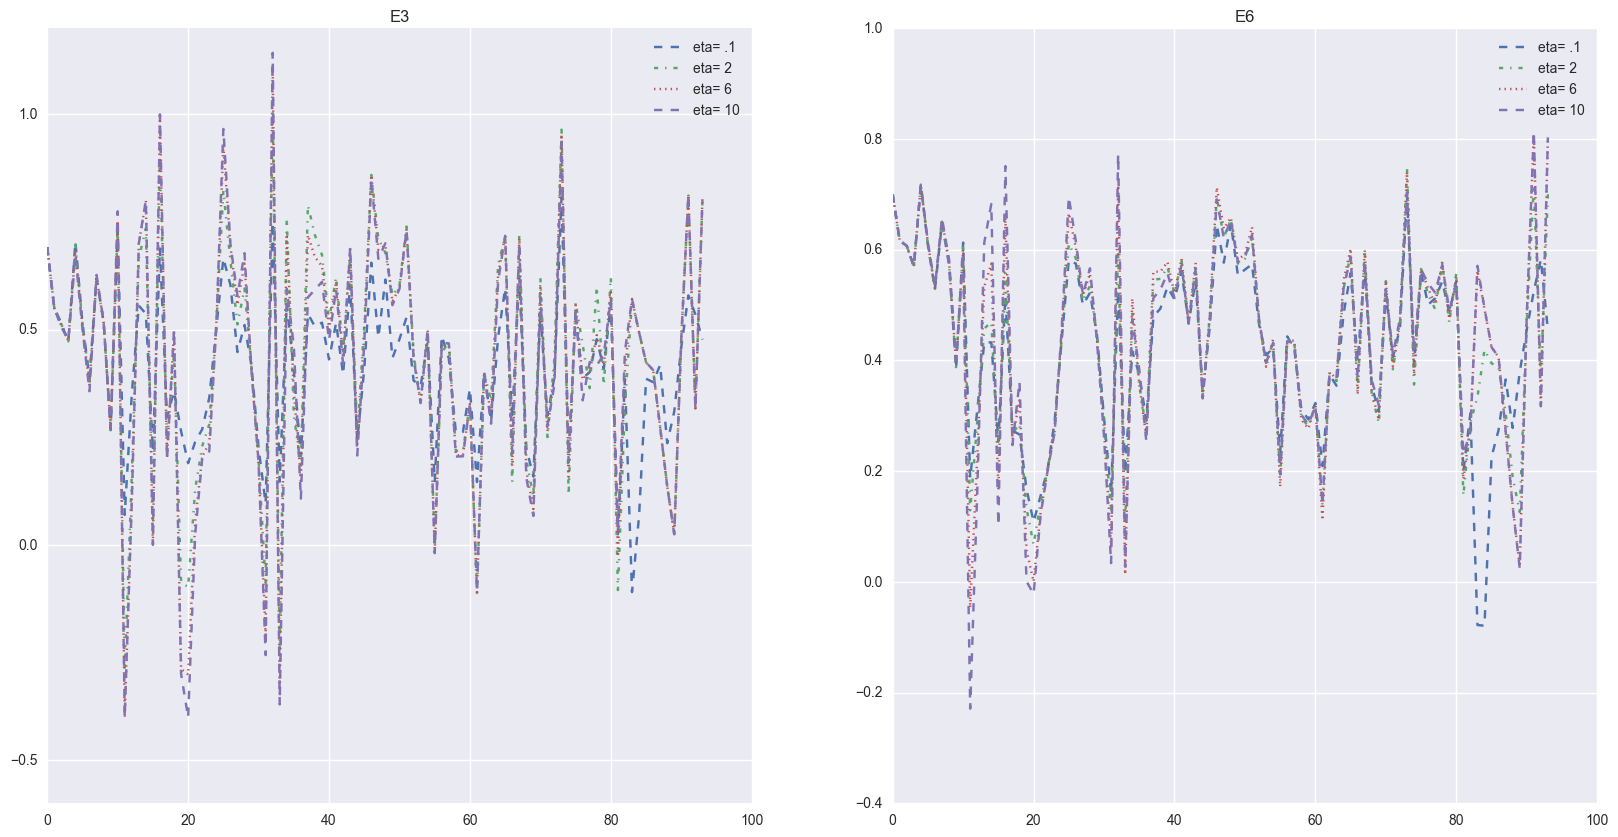

In [17]:
# Plot
plt.figure(figsize=(20,10))
line_style_vec=['--','-.',':','--']

plt.subplot(1,2,1)
i=0
for war_E3_pred in war_E3_pred_vec:
    plt.plot(war_E3_pred, label="eta= {0}".format(eta_vec[i]), linestyle=line_style_vec[i])
    i+=1
plt.legend()
plt.title("E3");

plt.subplot(1,2,2)
i=0
for war_E6_pred in war_E6_pred_vec:
    plt.plot(war_E6_pred, label="eta= {0}".format(eta_vec[i]), linestyle=line_style_vec[i])
    i+=1
plt.legend()
plt.title("E6");



RAS


### $L_{alg}$

#### Perte de premier ordre

In [18]:
def l1(loss_vec, weight_vec):
    """
    Cette fonction calcule les pertes l1
    l.w
    
    Argument(s) :
    - loss_vec : le vecteur des pertes l1 des
    M experts (np.array(T,M))
    - weight_vec : le vecteur des poids (np.array(T,M))
    
    Sortie(s) :
    - np.array(T,)"""
    return np.array([loss_vec[i+1].dot(weight_vec[i])\
              for i in range(len(weight_vec)-1)])

In [19]:
war_E3_cl1_01= l1(loss_vec_GE3,W_E3_01).cumsum()
war_E3_cl1_2= l1(loss_vec_GE3,W_E3_2).cumsum()
war_E3_cl1_6= l1(loss_vec_GE3,W_E3_6).cumsum()
war_E3_cl1_10= l1(loss_vec_GE3,W_E3_10).cumsum()

war_E6_cl1_01= l1(loss_vec_GE6,W_E6_01).cumsum()

war_E6_cl1_2= l1(loss_vec_GE6,W_E6_2).cumsum()
war_E6_cl1_6= l1(loss_vec_GE6,W_E6_6).cumsum()
war_E6_cl1_10= l1(loss_vec_GE6,W_E6_10).cumsum()

war_E3_cl1_vec=[war_E3_cl1_01,war_E3_cl1_2,war_E3_cl1_6,war_E3_cl1_10]
war_E6_cl1_vec=[war_E6_cl1_01,war_E6_cl1_2,war_E6_cl1_6,war_E6_cl1_10]

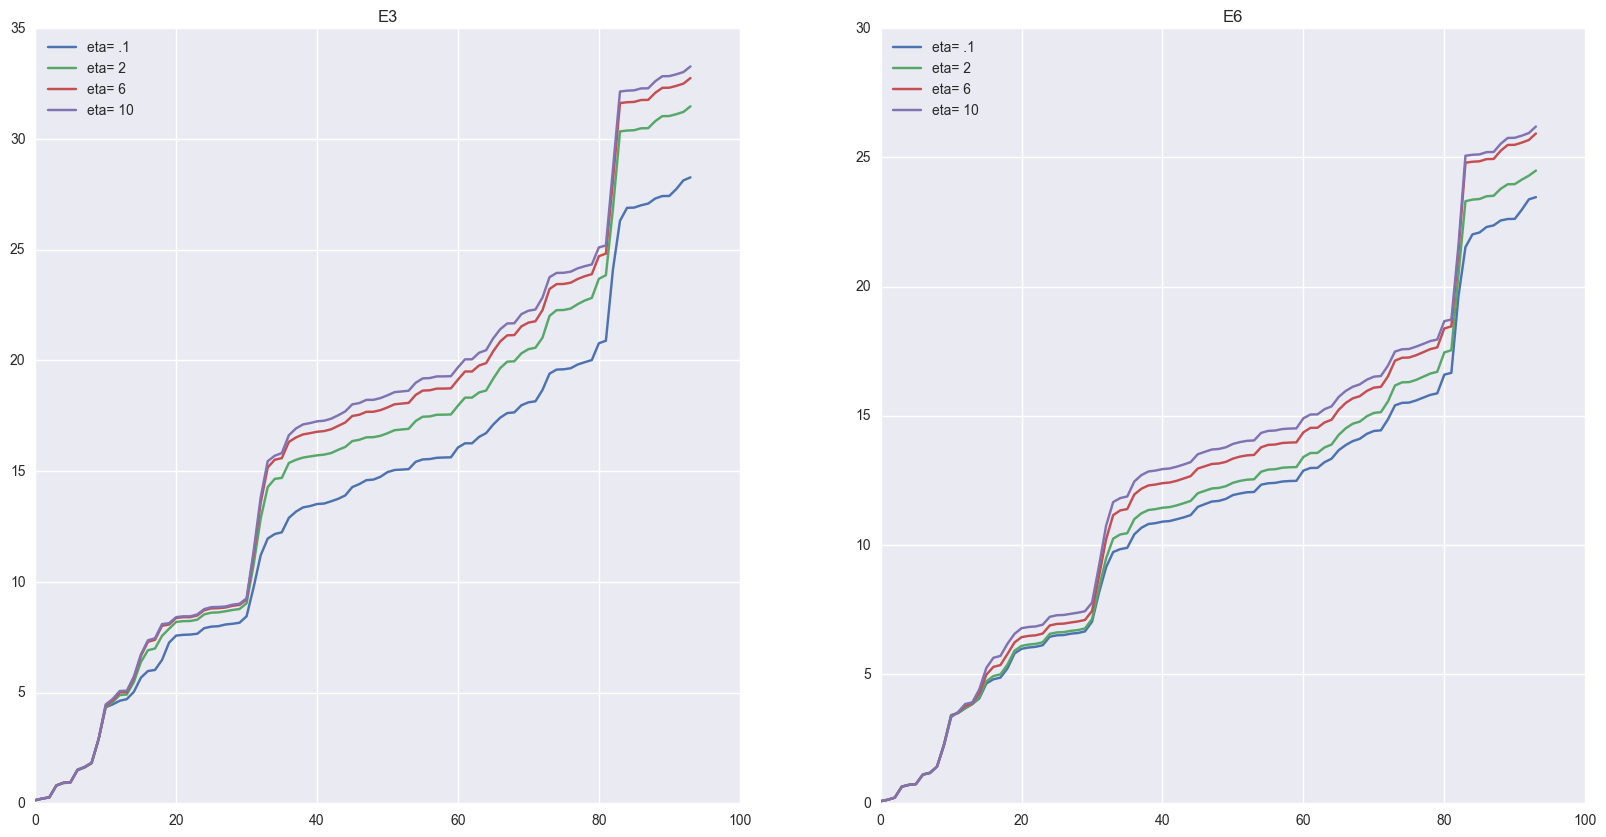

In [20]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
i=0
for war_E3_cl1 in war_E3_cl1_vec:
    plt.plot(war_E3_cl1, label="eta= {0}".format(eta_vec[i]))
    i+=1
plt.legend(loc=2)
plt.title("E3");

plt.subplot(1,2,2)
i=0
for war_E6_cl1 in war_E6_cl1_vec:
    plt.plot(war_E6_cl1, label="eta= {0}".format(eta_vec[i]))
    i+=1
plt.legend(loc=2)
plt.title("E6");

#### Perte de second ordre

In [21]:
def l2(C_vec, weight_vec):
    """
    Cette fonction calcule les pertes l2
    w^T.C.w
    
    Argument(s) :
    - C_vec : le vecteur des matrices de 
    variance-covariance des M experts (np.array(T-1,M,M))
    - weight_vec : le vecteur des poids (np.array(T,M))
    
    Sortie(s) :
    - np.array(T,)"""
    return np.array([weight_vec[i].T.dot(C_vec[i]).dot(weight_vec[i]) \
                for i in range(len(C_vec))]).reshape(len(C_vec))

In [22]:
war_E3_cl2_01= l2(C_E3_01,W_E3_01).cumsum()
war_E3_cl2_2= l2(C_E3_2,W_E3_2).cumsum()
war_E3_cl2_6= l2(C_E3_6,W_E3_6).cumsum()
war_E3_cl2_10= l2(C_E3_10,W_E3_10).cumsum()

war_E6_cl2_01= l2(C_E6_01,W_E6_01).cumsum()
war_E6_cl2_2= l2(C_E6_2,W_E6_2).cumsum()
war_E6_cl2_6= l2(C_E6_6,W_E6_6).cumsum()
war_E6_cl2_10= l2(C_E6_10,W_E6_10).cumsum()

war_E3_cl2_vec=[war_E3_cl2_01,war_E3_cl2_2,war_E3_cl2_6,war_E3_cl2_10]
war_E6_cl2_vec=[war_E6_cl2_01,war_E6_cl2_2,war_E6_cl2_6,war_E6_cl2_10]

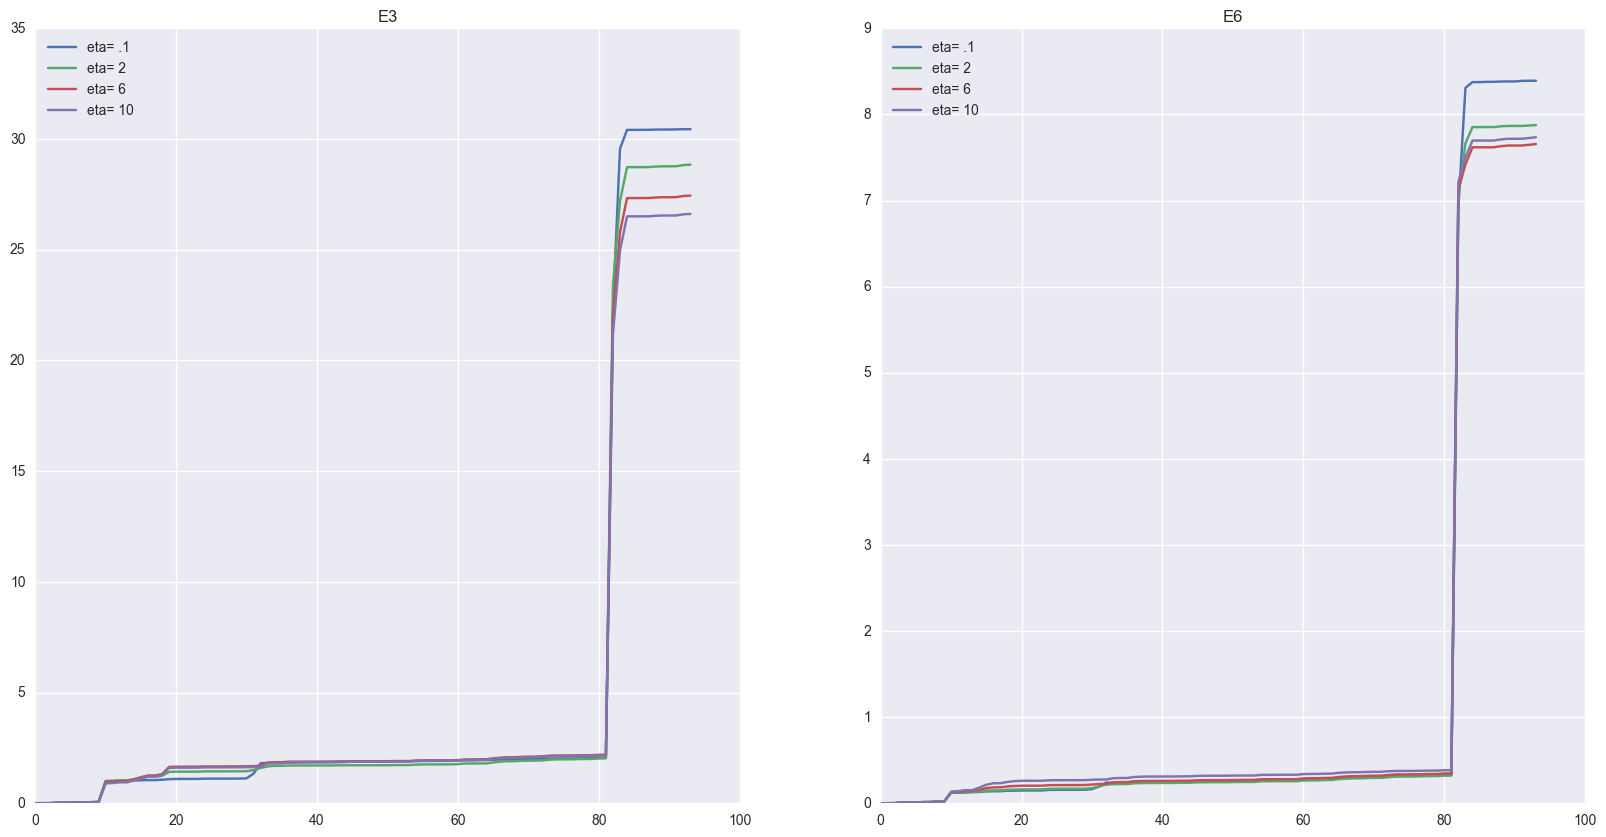

In [23]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
i=0
for war_E3_cl2 in war_E3_cl2_vec:
    plt.plot(war_E3_cl2, label="eta= {0}".format(eta_vec[i]))
    i+=1
plt.legend(loc=2)
plt.title("E3");

plt.subplot(1,2,2)
i=0
for war_E6_cl2 in war_E6_cl2_vec:
    plt.plot(war_E6_cl2, label="eta= {0}".format(eta_vec[i]))
    i+=1
plt.legend(loc=2)
plt.title("E6");


Remarques : 

- On ne voit pas véritablement de trade-off entre erreur cumulée en L1 et L2. Dataset ? Optimisation sur eta ?
- En revanche, pour une même perte L1, on obtient des pertes L2 significativement différentes

## Optimisation

In [24]:
dict={}
for i in range(101):
    j=i/10
    dict[j]=i*10

In [25]:
C_E3_dict={}
W_E3_dict={}
C_E6_dict={}
W_E6_dict={}
l1_E3_dict={}
l2_E3_dict={}
l1_E6_dict={}
l2_E6_dict={}
l1_E3_cs_vec=[]
l1_E6_cs_vec=[]
l2_E3_cs_vec=[]
l2_E6_cs_vec=[]

for eta in range(101):
    
    C_E3_dict["C_E3_"+str(eta)], W_E3_dict["W_E3_"+str(eta)] =\
    war_algo(loss_vec=loss_vec_GE3, eta=eta/10)
    C_E6_dict["C_E6_"+str(eta)], W_E6_dict["W_E6_"+str(eta)] =\
    war_algo(loss_vec=loss_vec_GE6, eta=eta/10)
    
    l1_E3_dict["l1_E3_"+str(eta)]= \
    l1(loss_vec=loss_vec_GE3, weight_vec=W_E3_dict["W_E3_"+str(eta)])
    l1_E6_dict["l1_E6_"+str(eta)]= \
    l1(loss_vec=loss_vec_GE6, weight_vec=W_E6_dict["W_E6_"+str(eta)])
    
    l2_E3_dict["l2_E3_"+str(eta)]= \
    l2(C_vec=C_E3_dict["C_E3_"+str(eta)], weight_vec=W_E3_dict["W_E3_"+str(eta)])
    l2_E6_dict["l2_E6_"+str(eta)]= \
    l2(C_vec=C_E6_dict["C_E6_"+str(eta)], weight_vec=W_E6_dict["W_E6_"+str(eta)])
    
    l1_E3_cs_vec+=[max(l1_E3_dict["l1_E3_"+str(eta)].cumsum())]
    l1_E6_cs_vec+=[max(l1_E6_dict["l1_E6_"+str(eta)].cumsum())]
    l2_E3_cs_vec+=[max(l2_E3_dict["l2_E3_"+str(eta)].cumsum())]
    l2_E6_cs_vec+=[max(l2_E6_dict["l2_E6_"+str(eta)].cumsum())]

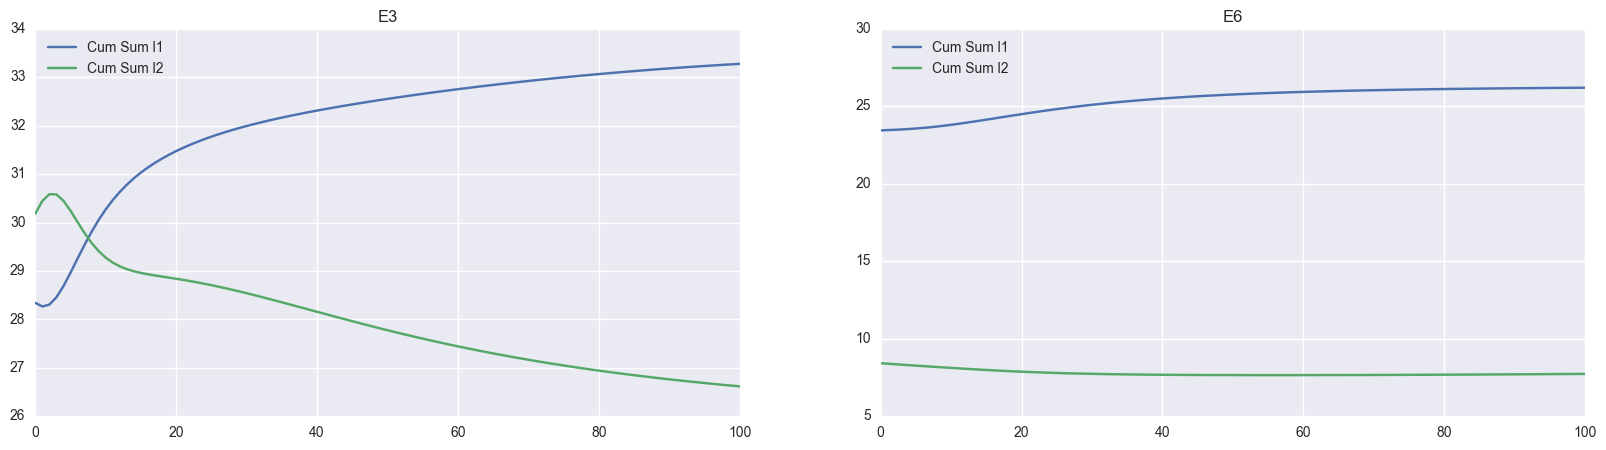

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(l1_E3_cs_vec, label="Cum Sum l1")
plt.plot(l2_E3_cs_vec, label="Cum Sum l2")
plt.title("E3")
plt.legend(loc=2);

plt.subplot(1,2,2)
plt.plot(l1_E6_cs_vec, label="Cum Sum l1")
plt.plot(l2_E6_cs_vec, label="Cum Sum l2")
plt.title("E6")
plt.legend(loc=2);

**Remarque** :

On constate un trade-off entre minimisation de la perte (l1) et de la variance (l2) ce qui justifie en creux notre étude. Dans ce contexte, l'importance de développer un algorithme permettant de minimiser la variance pour une perte (respectivement un gain) donnée prend toute son importance. 

[Graphqiue intéressant à développer]

# Application de la méthode de la sphère unitaire

In [27]:
from numpy import linalg as LA
import scipy

In [28]:
def war_algo_unit(loss_vec, eta=.3, t0=1):
    """
    Cette fonction implémente l'algorithme de 
    minimisation de la variance en ligne dans un
    cadre d'apprentissage en ligne avec experts
    sur la sphère unitaire
    Voir Warmuth et Kuzmin (2006)
    
    Hyper-paramètre(s)
    eta : (st pos) parametre de tuning
    
    Argument(s)
    loss_vec : (np.array(T,M)) le vecteur 
    des pertes des experts à chaque date
    t0: la première période considérée dans nos 
    itérations
    
    Sortie(s)
    W : (np.array(T,M,1)) vecteur des poids au 
    cours des T périodes
    C : (np.array(T-t0,M,M)) vecteur des matrices 
    de variance-covariance du portefeuille 
    au cours des T-t0 périodes
    
    Beware : on commence en t=1 car y1=nan en période 0 
    """
    # Init
    M= loss_vec.shape[1] # Détermine le nombre d'experts
    w= (np.eye(M)/M).reshape(M,M) # Poids répartis de manière uniforme
    We= [(1/M)*np.ones(M),] # Ce vecteur récolte les poids de manière itérative, initialisé proba uniforme
    C_sum=np.zeros([M,M]) # Ce vecteur somme les mat var-cov pour calculer les nouveaux poids
    loss=[] # Ce vecteur récupère les loss du portefeuille

    # Date t
    for i in range(t0,len(db)): # Attention, par défaut on commence à t0=1
        l= loss_vec[i].reshape(M,1)
        l_bar= l.T.dot(l/M)
        #print(l_bar.shape)

        c= (1/M)*(l-l_bar).dot((l-l_bar).T)
        C_sum=np.add(C_sum,c) #Somme des mat de var cov jusqu'a t=i

        w_num= scipy.linalg.expm(-eta * C_sum)
        w_denom= np.matrix.trace(w_num)
        w_new= w_num/w_denom
        
        eigenvalues, eigenvectors = LA.eig(w_new)
        We+=[eigenvalues] 
        loss+=[np.matrix.trace(np.dot(w_new,c))]

    loss=np.array(loss)
    We=np.array(We).reshape(len(db),M)
    return(loss,We)

## Résultats

In [29]:
# Calcul des poids et matrices de var-covariance pour différents
# sets d'experts et différentes valeurs de eta

## GE3
C_E3_005, W_E3_005= war_algo_unit(loss_vec= loss_vec_GE3, eta= .05)
C_E3_01, W_E3_01= war_algo_unit(loss_vec= loss_vec_GE3, eta= .1)
C_E3_02, W_E3_02= war_algo_unit(loss_vec= loss_vec_GE3, eta= .2)
C_E3_10, W_E3_10= war_algo_unit(loss_vec= loss_vec_GE3, eta= 10)

## GE6
C_E6_005, W_E6_005=war_algo_unit(loss_vec= loss_vec_GE6, eta= .05)
C_E6_01, W_E6_01=war_algo_unit(loss_vec= loss_vec_GE6, eta= .1)
C_E6_02, W_E6_02=war_algo_unit(loss_vec= loss_vec_GE6, eta= .2)
C_E6_10, W_E6_10=war_algo_unit(loss_vec= loss_vec_GE6, eta= 10)

In [30]:
# Vec
C_E3_vec= [C_E3_005, C_E3_01, C_E3_02, C_E3_10]
C_E6_vec= [C_E6_005, C_E6_01, C_E6_02, C_E6_10]
W_E3_vec= [W_E3_005, W_E3_01, W_E3_02, W_E3_10]
W_E6_vec= [W_E6_005, W_E6_01, W_E6_02, W_E6_10]
eta_vec= [".005" , ".01", "0.2", "10"]

### Poids

/Users/Gauthier/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


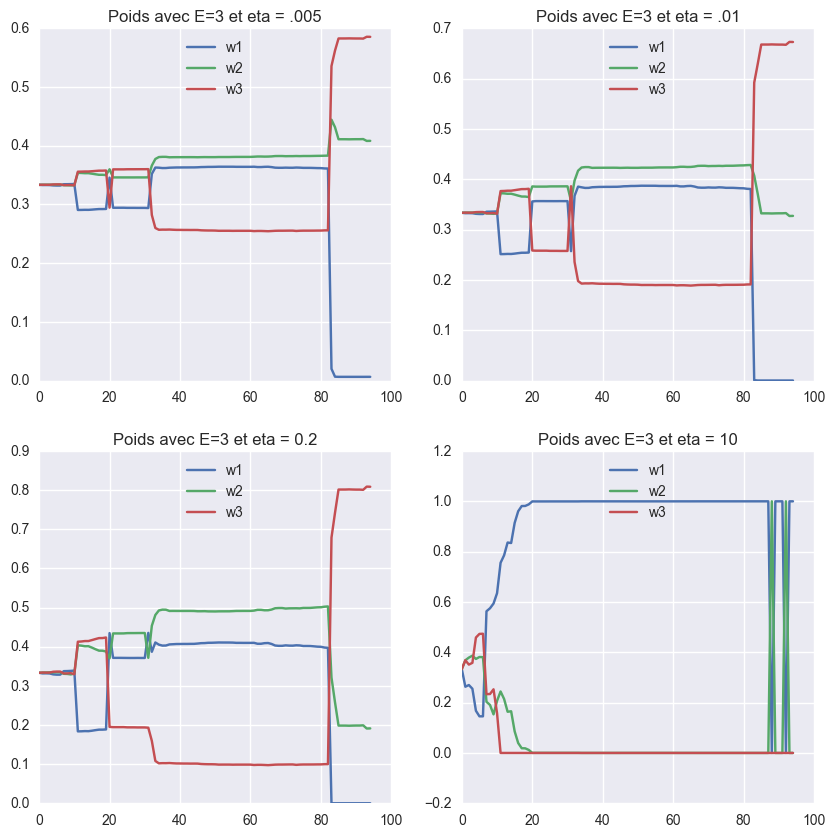

In [31]:
# Plot pour E=3
plt.figure(figsize=(10,10))
j=0
for W in W_E3_vec:
    j+=1
    plt.subplot(2,2,j)
    for i in range(W.shape[1]):
        plt.plot(extract_weight(W)[i],label="w"+str(i+1))
    plt.title("Poids avec E=3 et eta = {0}".format(eta_vec[j-1]))
    plt.legend(loc=9);

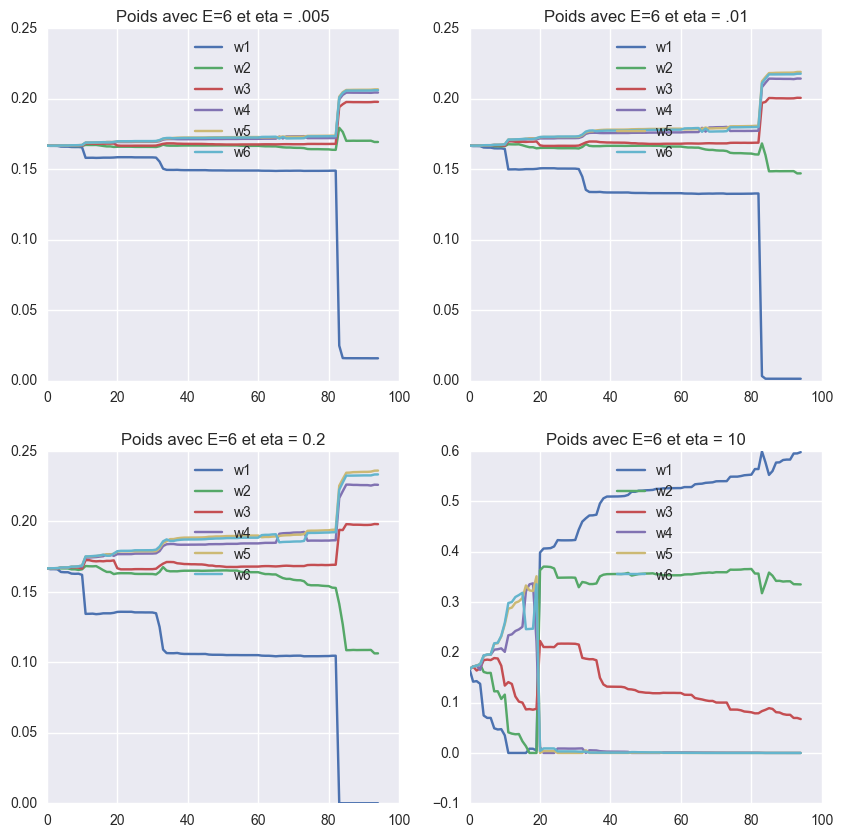

In [32]:
# Plot pour E=6
plt.figure(figsize=(10,10))
j=0
for W in W_E6_vec:
    j+=1
    plt.subplot(2,2,j)
    for i in range(W.shape[1]):
        plt.plot(extract_weight(W)[i],label="w"+str(i+1))
    plt.title("Poids avec E=6 et eta = {0}".format(eta_vec[j-1]))
    plt.legend(loc=9);

Remarques : 

- A mesure que $\eta \rightarrow \infty$, l'algorithme tend à se spécialiser sur la minimisation de la perte "instantanée". En contrepartie, il accorde moins d'importance à l'enthropie (mesurée par la divergence de Kullback-Leibler). On constate ainsi une plus forte volatilités des poids à mesure que $\eta$ grandit. On peut également s'attendre à ce que cela se traduise par une baisse des performances de l'algorithme (perte de généralisation). 
- **E3** : Pour des valeurs modérées de $\eta$, $w$ tend à charger $\hat{y}_2=0.4$. C'est également le cas de l'estimateur EWA. Intuition: Perte faible et peu variable.
- **E_6** : Pour des valeurs modérées de $\eta$, $w$ tend à charger $\hat{y}_5$. C'est également le cas de l'estimateur EWA. Intuition : perte faible et peu corrélé aux autres (seul y_6 incorpore $c_t$). ???

### $L_{alg}$

#### Perte de premier ordre

In [33]:
war_E3_cl1_01= l1(loss_vec_GE3,W_E3_01).cumsum()
war_E3_cl1_2= l1(loss_vec_GE3,W_E3_2).cumsum()
war_E3_cl1_6= l1(loss_vec_GE3,W_E3_6).cumsum()
war_E3_cl1_10= l1(loss_vec_GE3,W_E3_10).cumsum()

war_E6_cl1_01= l1(loss_vec_GE6,W_E6_01).cumsum()

war_E6_cl1_2= l1(loss_vec_GE6,W_E6_2).cumsum()
war_E6_cl1_6= l1(loss_vec_GE6,W_E6_6).cumsum()
war_E6_cl1_10= l1(loss_vec_GE6,W_E6_10).cumsum()

war_E3_cl1_vec=[war_E3_cl1_01,war_E3_cl1_2,war_E3_cl1_6,war_E3_cl1_10]
war_E6_cl1_vec=[war_E6_cl1_01,war_E6_cl1_2,war_E6_cl1_6,war_E6_cl1_10]

/Users/Gauthier/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


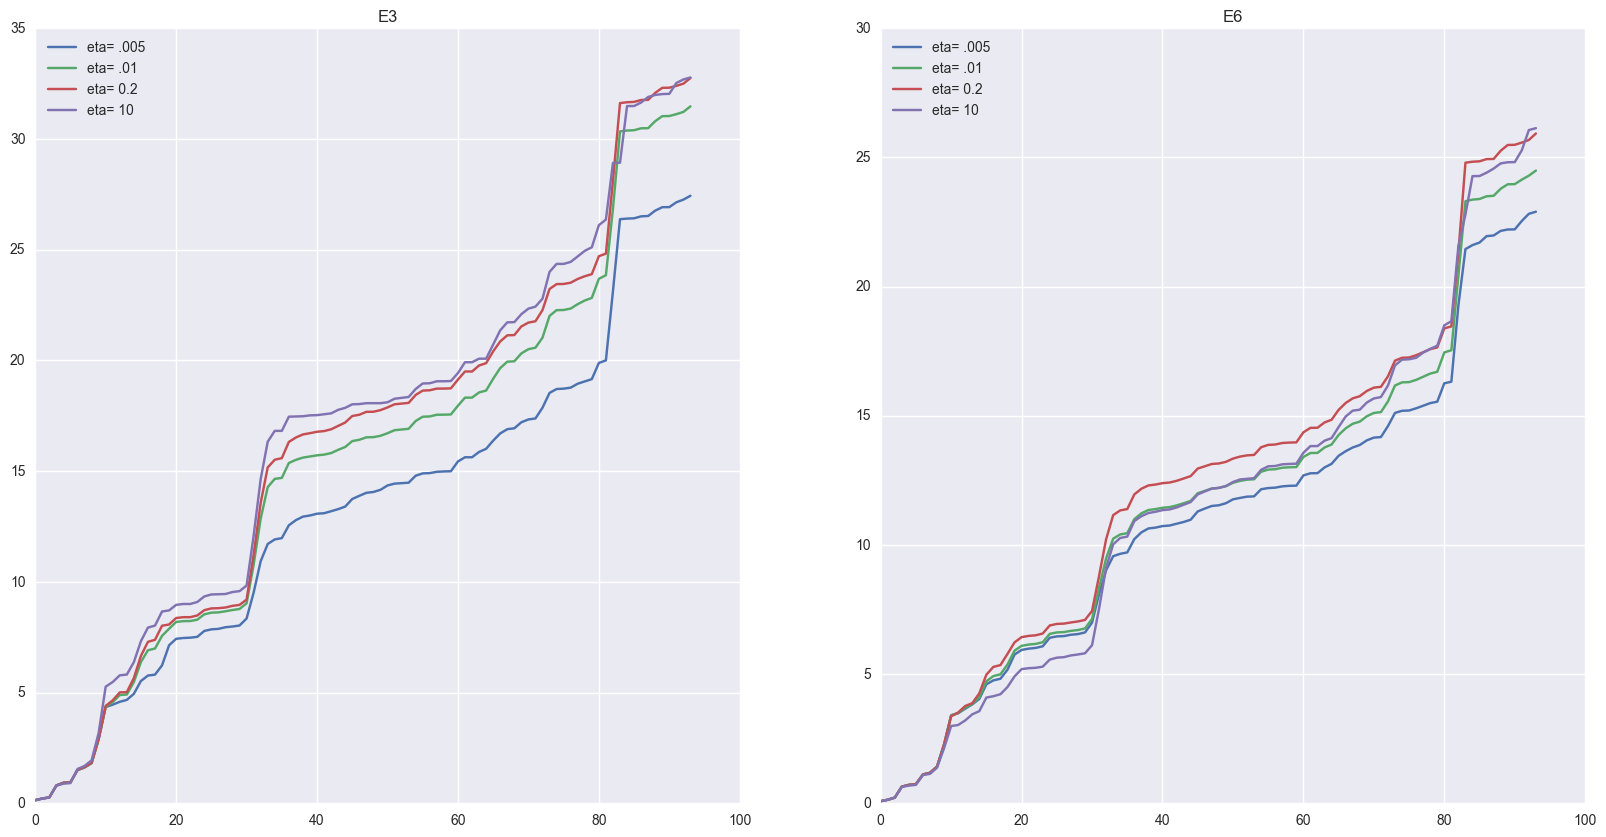

In [34]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
i=0
for war_E3_cl1 in war_E3_cl1_vec:
    plt.plot(war_E3_cl1, label="eta= {0}".format(eta_vec[i]))
    i+=1
plt.legend(loc=2)
plt.title("E3");

plt.subplot(1,2,2)
i=0
for war_E6_cl1 in war_E6_cl1_vec:
    plt.plot(war_E6_cl1, label="eta= {0}".format(eta_vec[i]))
    i+=1
plt.legend(loc=2)
plt.title("E6");

#### Perte de second ordre

In [35]:
C_E3_005, W_E3_005= war_algo_unit(loss_vec= loss_vec_GE3, eta= .05)
C_E3_01, W_E3_01= war_algo_unit(loss_vec= loss_vec_GE3, eta= .1)
C_E3_02, W_E3_02= war_algo_unit(loss_vec= loss_vec_GE3, eta= .2)
C_E3_10, W_E3_10= war_algo_unit(loss_vec= loss_vec_GE3, eta= 10)

## GE6
C_E6_005, W_E6_005=war_algo_unit(loss_vec= loss_vec_GE6, eta= .05)
C_E6_01, W_E6_01=war_algo_unit(loss_vec= loss_vec_GE6, eta= .1)
C_E6_02, W_E6_02=war_algo_unit(loss_vec= loss_vec_GE6, eta= .2)
C_E6_10, W_E6_10=war_algo_unit(loss_vec= loss_vec_GE6, eta= 10)

In [36]:
war_E3_cl2_005= C_E3_005.cumsum()
war_E3_cl2_01= C_E3_01.cumsum()
war_E3_cl2_02= C_E3_02.cumsum()
war_E3_cl2_10= C_E3_10.cumsum()

war_E6_cl2_005= C_E6_005.cumsum()
war_E6_cl2_01= C_E6_01.cumsum()
war_E6_cl2_02= C_E6_02.cumsum()
war_E6_cl2_10= C_E6_10.cumsum()

war_E3_cl2_vec=[war_E3_cl2_005,war_E3_cl2_01,war_E3_cl2_02,war_E3_cl2_10]
war_E6_cl2_vec=[war_E6_cl2_005,war_E6_cl2_01,war_E6_cl2_02,war_E6_cl2_10]

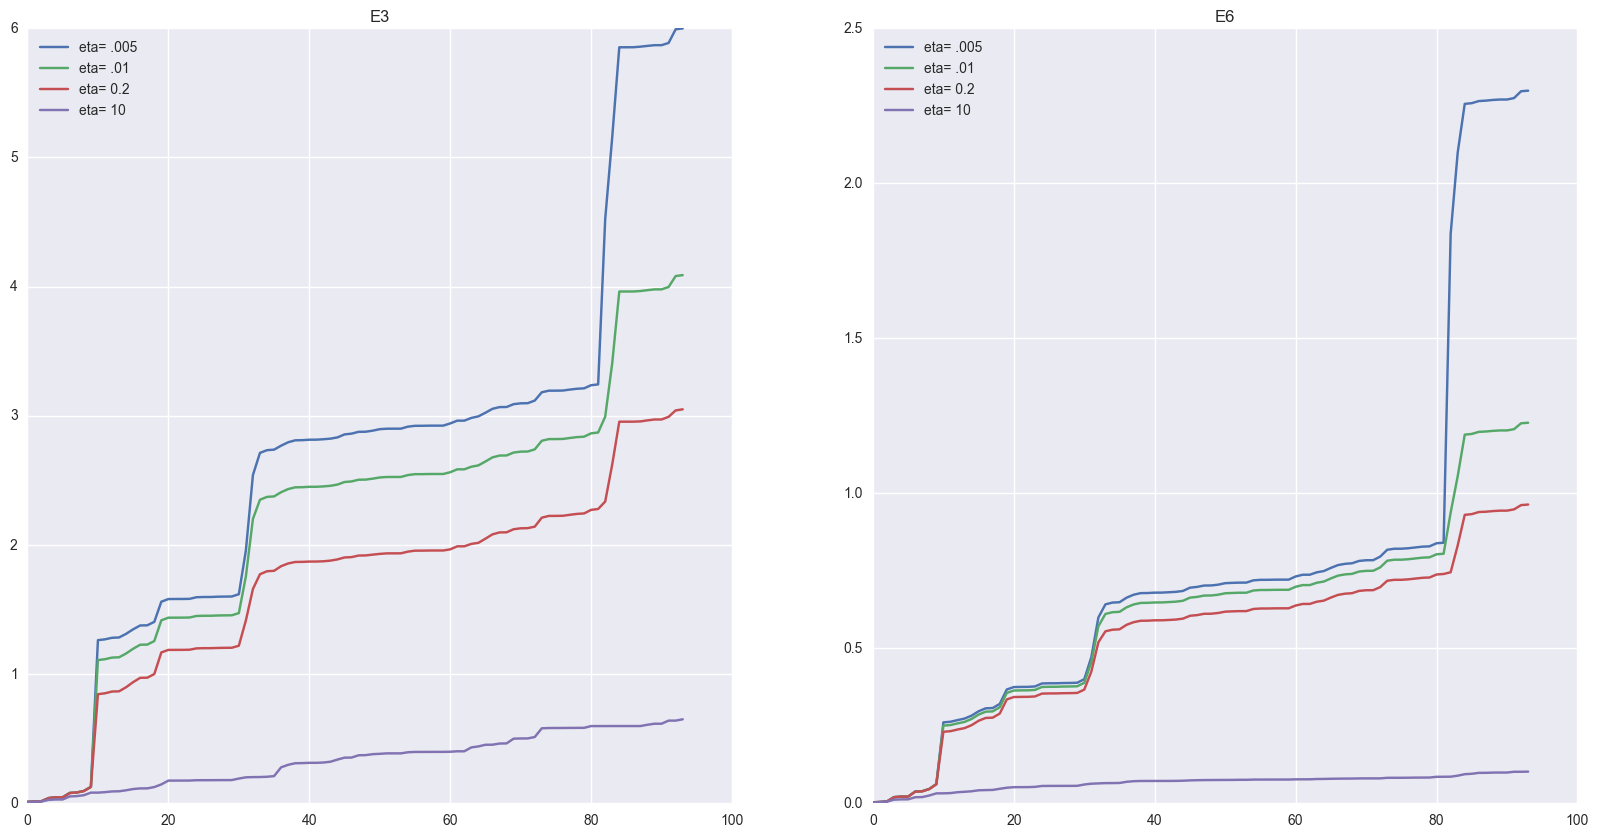

In [37]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
i=0
for war_E3_cl2 in war_E3_cl2_vec:
    plt.plot(war_E3_cl2, label="eta= {0}".format(eta_vec[i]))
    i+=1
plt.legend(loc=2)
plt.title("E3");

plt.subplot(1,2,2)
i=0
for war_E6_cl2 in war_E6_cl2_vec:
    plt.plot(war_E6_cl2, label="eta= {0}".format(eta_vec[i]))
    i+=1
plt.legend(loc=2)
plt.title("E6");


## Optimisation

In [38]:
dict={}
for i in range(101):
    j=i/10
    dict[j]=i*10

In [39]:
C_E3_dict={}
W_E3_dict={}
C_E6_dict={}
W_E6_dict={}
l1_E3_dict={}
l2_E3_dict={}
l1_E6_dict={}
l2_E6_dict={}
l1_E3_cs_vec=[]
l1_E6_cs_vec=[]
l2_E3_cs_vec=[]
l2_E6_cs_vec=[]

for eta in range(101):
    
    l2_E3_dict["l2_E3_"+str(eta)], W_E3_dict["W_E3_"+str(eta)],  =\
    war_algo_unit(loss_vec=loss_vec_GE3, eta=eta/100)
    l2_E6_dict["l2_E6_"+str(eta)], W_E6_dict["W_E6_"+str(eta)],  =\
    war_algo_unit(loss_vec=loss_vec_GE6, eta=eta/100)
    
    l1_E3_dict["l1_E3_"+str(eta)]= \
    l1(loss_vec=loss_vec_GE3, weight_vec=W_E3_dict["W_E3_"+str(eta)])
    l1_E6_dict["l1_E6_"+str(eta)]= \
    l1(loss_vec=loss_vec_GE6, weight_vec=W_E6_dict["W_E6_"+str(eta)])
    
    
    l1_E3_cs_vec+=[max(l1_E3_dict["l1_E3_"+str(eta)].cumsum())]
    l1_E6_cs_vec+=[max(l1_E6_dict["l1_E6_"+str(eta)].cumsum())]
    l2_E3_cs_vec+=[max(l2_E3_dict["l2_E3_"+str(eta)].cumsum())]
    l2_E6_cs_vec+=[max(l2_E6_dict["l2_E6_"+str(eta)].cumsum())]

/Users/Gauthier/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


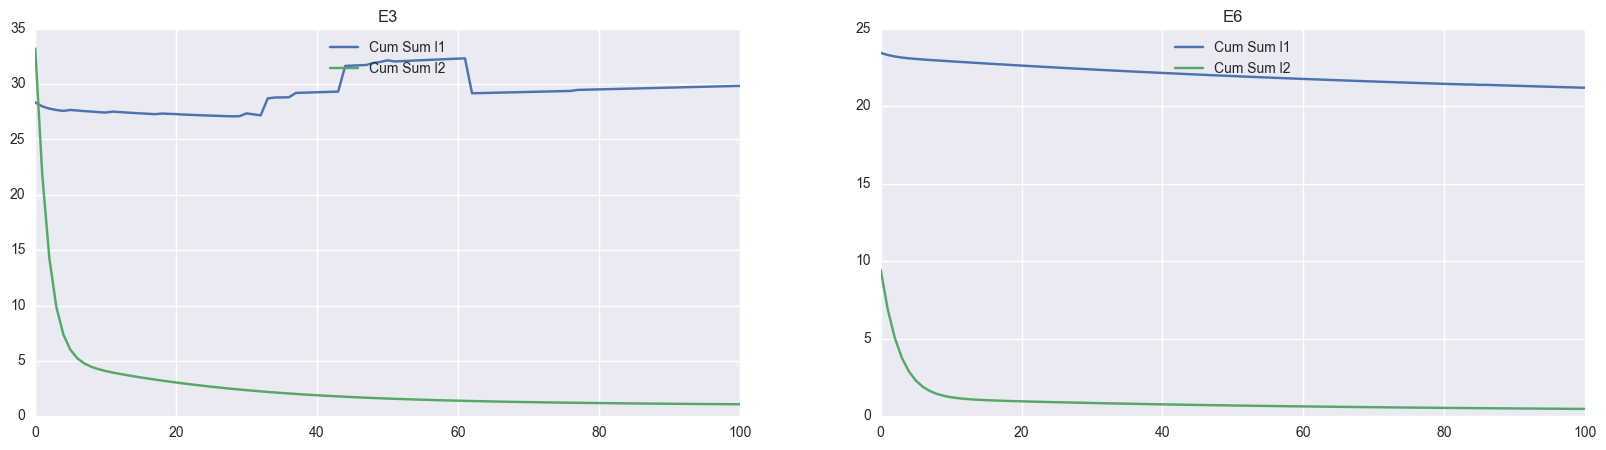

In [40]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(l1_E3_cs_vec, label="Cum Sum l1")
plt.plot(l2_E3_cs_vec, label="Cum Sum l2")
plt.title("E3")
plt.legend(loc=9);

plt.subplot(1,2,2)
plt.plot(l1_E6_cs_vec, label="Cum Sum l1")
plt.plot(l2_E6_cs_vec, label="Cum Sum l2")
plt.title("E6")
plt.legend(loc=9);

# Calcul de $\eta$ optimal

In [41]:
def optimal_eta(loss_vec, t0=1):
    """
    Cette fonction calcule le eta optimal 
    d'après la fonction fournie par l'article
    
    Argument(s)
    M : le nombre d'experts
    loss_vec : (np.array(T,M)) le vecteur 
    des pertes des experts à chaque date
    t0: la première période considérée dans nos 
    itérations
    
    Sortie(s)
    eigenvalues[i]: valeur propre minimale de la somme des var-cov
    eigenvectors[i]: vecteur propre associé
    Lu: perte pour la dyad optimale
    r: paramètre utile au calcul de eta optimal
    eta : eta optimal pour les bonnes propriétés sur le risque
    """
    # Init
    M= loss_vec.shape[1] # Détermine le nombre d'experts
    C_sum=np.zeros([M,M]) # Ce vecteur somme les mat var-cov pour calculer les nouveaux poids
    C=[] # Ce vecteur sert à stocker les différentes matrices de var-cov
    n = len(db) # Nombre d'observations
    # Date t
    for i in range(t0,n): # Attention, par défaut on commence à t0=1
        l= loss_vec[i].reshape(M,1)
        l_bar= l.T.dot(l/M)

        c= (1/M) *(l-l_bar).dot((l-l_bar).T)
        C_sum=np.add(C_sum,c) #Somme des mat de var cov jusqu'a t=i
        C += [c]

    eigenvalues, eigenvectors = LA.eig(C_sum)
    i=np.argmin(eigenvalues) #On récupère l'indice de la plus petite vap
    
    # Pour ce vep, on regarde Lu
    Lu = np.dot(eigenvectors[i], np.dot(C_sum, eigenvectors[i].T))
    
    # On cherche r, le maximum des termes de la matrice de variance covariance
    r = np.amax(C)*2
    
    # A partir de ces différents éléments on peut trouver le eta optimal
    eta = (2*np.sqrt(Lu*np.log(n)))/(r*np.sqrt(np.log(n))+np.sqrt(r*Lu))
    
    return(eigenvalues[i],eigenvectors[i], Lu, r, eta)

In [42]:
lam,u, Lu, r, eta_opt = optimal_eta(loss_vec_GE6)
print("valeur propre minimale",lam)
print("vecteur propre associe",u)
print('Lu',Lu)
print('r',r)
print('Eta optimal',eta_opt)

valeur propre minimale 0.0315648089624
vecteur propre associe [ 0.49073937  0.10388445  0.44623179  0.25283358  0.02724952 -0.69612695]
Lu 3.38725156674
r 19.0197808737
Eta optimal 0.161577077526


On vérifie que u appartienne bien à la sphère unitaire

In [43]:
u.dot(u)

1.0000000000000027

### On lance l'algorithme pour $\eta$ optimal

In [44]:
C_E6_opt, W_E6_opt=war_algo_unit(loss_vec= loss_vec_GE6, eta= eta_opt)

Erreur second ordre 1.01771989275


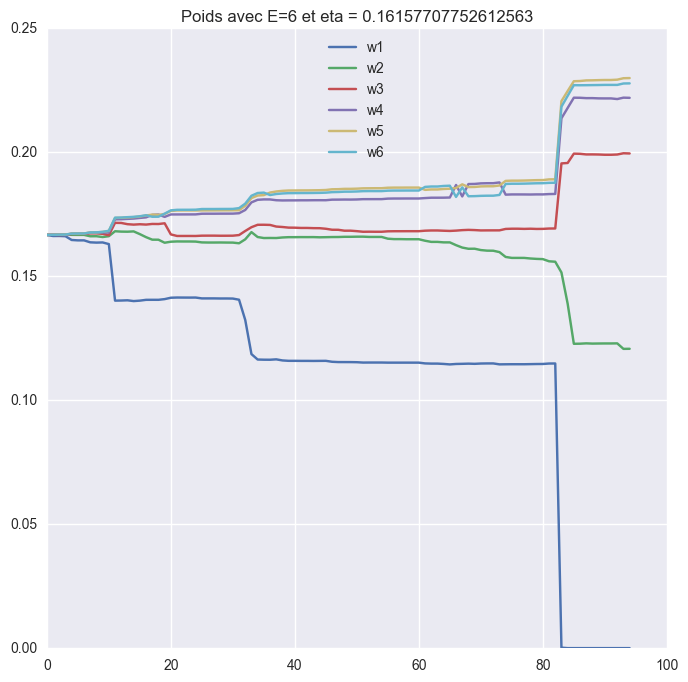

In [45]:
# Plot pour E=6
plt.figure(figsize=(8,8))
for i in range(W_E6_opt.shape[1]):
    plt.plot(extract_weight(W_E6_opt)[i],label="w"+str(i+1))
plt.title("Poids avec E=6 et eta = {0}".format(eta_opt))
plt.legend(loc=9);
print ("Erreur second ordre",np.sum(C_E6_opt))